In [88]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pprint
import csv
import datetime
import math




In [89]:
# import and process new data

In [90]:
def extract_time(t1,t2,t3=None,t4=None):
    
    if isinstance(t1,float) and isinstance(t2,float) and isinstance(t3,float) and isinstance(t4,float):
        return (t2-t1)+(t4-t3)

    if isinstance(t1,float) and isinstance(t2,float) and t3 is None and t4 is None:
        return t2-t1
    
    if isinstance(t1,basestring):
        try:
            t1 = datetime.datetime.strptime(t1, "%Y-%m-%d %H:%M:%S.%f")
        except:
            t1 = datetime.datetime.strptime(t1, "%Y-%m-%d %H:%M:%S")
    
    if isinstance(t2,basestring):
        try:
            t2  = datetime.datetime.strptime(t2, "%Y-%m-%d %H:%M:%S.%f")
        except:
            t2  = datetime.datetime.strptime(t2, "%Y-%m-%d %H:%M:%S")

    if t3 is not None and isinstance(t3,basestring):
        
        try:
            t3   = datetime.datetime.strptime(t3, "%Y-%m-%d %H:%M:%S.%f")
        except:
            t3   = datetime.datetime.strptime(t3, "%Y-%m-%d %H:%M:%S")
    
    if t4 is not None and isinstance(t4,basestring):
        try:
            t4  = datetime.datetime.strptime(t4, "%Y-%m-%d %H:%M:%S.%f")
        except:
            t4  = datetime.datetime.strptime(t4, "%Y-%m-%d %H:%M:%S")
            
            
        return ((t2-t1)+(t4-t3)).total_seconds()
    
    else:
        if t3 is not None and t4 is not None:
            return ((t2-t1)+(t4-t3)).total_seconds()
        else:        
            return (t2-t1).total_seconds()

In [91]:
def extract_core_overhead(df):
    alloc_start,alloc_stop,dealloc_start,dealloc_stop = df['timestamp']
    core_ov = extract_time(alloc_start,alloc_stop,dealloc_start,dealloc_stop)
    
    return core_ov

In [92]:
def extract_pat_overhead(df):
    #pre_loop_df = df[0:1]
    sim_df = df[1:7]
    ana_df = df[7:]
    
    #start,wait,res,stop = pre_loop_df['timestamp']    
    #pre_loop_ov = extract_time(start,wait,res,stop)
    
    
    #print sim_df['timestamp']
    
    start1,wait1,res1,stop1,start2,stop2 = sim_df['timestamp']
    part1 = extract_time(start1,wait1,res1,stop1)
    #part2 = extract_time(start2,wait2,res2,stop2)
    #post = extract_time(post_start,post_stop)    
    sim_ov = part1 #+ part2 + post

    start1,wait1,res1,stop1,start2,stop2 = ana_df['timestamp']
    part1 = extract_time(start1,wait1,res1,stop1)
    #part2 = extract_time(start2,wait2,res2,stop2)
    #post = extract_time(post_start,post_stop)    
    ana_ov = part1 #+ part2 + post
    
    return sim_ov+ana_ov
    

In [93]:
def extract_timing_info(df,cores,inst):
    
    sim_data,ana_data = extract_data_time(df,cores,inst)
    sim_exec,ana_exec = extract_exec_time(df,cores,inst)
    
    return [sim_data,ana_data],[sim_exec,ana_exec]

In [94]:
def extract_data_time(df,cores,inst):
    req_df = df[['step','StagingInput','Allocating','AgentStagingOutputPending','Done']]
    
    #preloop_df = req_df[:1]
    sim_df = req_df[1:-2]
    ana_df = req_df[-2:]
    
    #preloop_data = None
    sim_data = None
    ana_data = None
    
    
    # Preloop extraction
    #step,t1,t2,t3,t4 =  preloop_df.loc[0,:]
    #preloop_data = extract_time(t1,t2,t3,t4)
    
    
    #Simulation extraction
    per_unit_data_time  = list()
    for row in sim_df.iterrows():
        step,t1,t2,t3,t4 = row[1:][0]
        #print t1,t2,t3,t4
        #print row
        per_unit_data_time.append(extract_time(t1,t2,t3,t4))
        
    if cores == inst:
        kern_1 = per_unit_data_time[:inst]
        kern_2 = per_unit_data_time[inst:]
        sim_data = np.average(kern_1) + np.average(kern_2)
    elif inst > cores:
        pass
    
    
    #Analysis extraction
    per_unit_data_time  = list()
    for row in ana_df.iterrows():
        step,t1,t2,t3,t4 = row[1:][0]
        #print t1,t2,t3,t4
        #print row
        per_unit_data_time.append(extract_time(t1,t2,t3,t4))
        
    ana_data = sum(per_unit_data_time)
    
    #print preloop_data, sim_data, ana_data
    return sim_data, ana_data

In [95]:
def extract_exec_time(df,cores,inst):
    req_df = df[['step','Executing','AgentStagingOutputPending']]
    
    #preloop_df = req_df[:1]
    sim_df = req_df[1:-2]
    ana_df = req_df[-2:]
    
    #preloop_exec = None
    sim_exec = None
    ana_exec = None
    
    
    # Preloop extraction
    #step,t1,t2 =  preloop_df.loc[0,:]
    #preloop_exec = extract_time(t1,t2)

    
    #Simulation extraction
    #STUPID ME SET CORES PER CU = 2!!
    per_unit_exec_time  = list()
    for row in sim_df.iterrows():
        step,t1,t2 = row[1:][0]
        #print t1,t2,t3,t4
        #print row
        per_unit_exec_time.append(extract_time(t1,t2))
        
    if cores == inst:
        kern_1 = per_unit_exec_time[:inst]
        kern_2 = per_unit_exec_time[inst:]
        sim_exec = (np.average(kern_1) + np.average(kern_2))*2
    elif inst > cores:
        pass
    
  
    
    #Analysis extraction
    per_unit_exec_time  = list()
    for row in ana_df.iterrows():
        step,t1,t2 = row[1:][0]
        #print t1,t2,t3,t4
        #print row
        per_unit_exec_time.append(extract_time(t1,t2))
        
    ana_exec = sum(per_unit_exec_time)
    
    
    #print preloop_exec, sim_exec, ana_exec
    return sim_exec, ana_exec

In [96]:
def extract_rp_overhead(df,data,exec_list):
    
    #pre_loop_df = df[0:1]
    sim_df = df[1:7]
    ana_df = df[7:]
  
    '''
    start,wait,res,stop = pre_loop_df['timestamp'] 
    preloop_wait = extract_time(wait,res)
    preloop_rp_ov = preloop_wait - data[0] - exec_list[0]
    '''
    
    start1,wait1,res1,stop1,start2,stop2 = sim_df['timestamp']
    sim_wait = extract_time(wait1,res1)
    sim_rp_ov = sim_wait - data[1] - exec_list[1]
    
    start1,wait1,res1,stop1,start2,stop2 = ana_df['timestamp']
    ana_wait = extract_time(wait1,res1)
    ana_rp_ov = ana_wait - data[1] - exec_list[1]
    
    rp_ov = sim_rp_ov + ana_rp_ov
    
    
    #print preloop_rp_ov, sim_rp_ov, ana_rp_ov
    
    return rp_ov

In [97]:
def separate(comp_df,err_df):
    ov_df = pd.DataFrame(columns=['EnMD Core overhead',
                                'EnMD Pat overhead',
                                'RP overhead'])
    ov_df_err = pd.DataFrame(columns=['EnMD Core overhead',
                                'EnMD Pat overhead',
                                'RP overhead'])
    ov_df['EnMD Core overhead'] = comp_df['EnMD Core overhead']
    ov_df['EnMD Pat overhead'] = comp_df['EnMD Pat overhead']
    ov_df['RP overhead'] = comp_df['RP overhead']
    
    ov_df_err['EnMD Core overhead'] = err_df['EnMD Core overhead']
    ov_df_err['EnMD Pat overhead'] = err_df['EnMD Pat overhead']
    ov_df_err['RP overhead'] = err_df['RP overhead']
    
    
    
    app_df = pd.DataFrame(columns=['pre_loop execution time',
                                'sim execution time',
                                'ana execution time'])
    app_df_err = pd.DataFrame(columns=['pre_loop execution time',
                                'sim execution time',
                                'ana execution time'])
    #app_df['pre_loop execution time'] = comp_df['pre_loop execution time']
    app_df['sim execution time'] = comp_df['sim execution time']
    app_df['ana execution time'] = comp_df['ana execution time']
    
    #app_df_err['pre_loop execution time'] = err_df['pre_loop execution time']
    app_df_err['sim execution time'] = err_df['sim execution time']
    app_df_err['ana execution time'] = err_df['ana execution time']
    
    
    
    data_df = pd.DataFrame(columns=['data movement'])
    data_df_err = pd.DataFrame(columns=['data movement'])
    data_df['data movement'] = comp_df['data movement']
    data_df_err['data movement'] = err_df['data movement']
    
    split_plot([ov_df,ov_df_err],[app_df,app_df_err],[data_df,data_df_err])

In [104]:
#MAIN

comp_df = pd.DataFrame(columns=['EnMD Core overhead',
                                'EnMD Pat overhead',
                                'RP overhead',
                                'sim execution time',
                                'ana execution time',
                                'data movement'])

err_df = pd.DataFrame(columns=['EnMD Core overhead',
                                'EnMD Pat overhead',
                                'RP overhead',
                                'sim execution time',
                                'ana execution time',
                                'data movement'])

path = "/home/shenoy/Documents/Nikhil/research/enmd-pattern-testing/old/nikhil_postmortem_analyses/strong_scaling/temp/"
cores = [1,16,32,64,128]
trials = 4
for c in cores:
    
    core_ov_list = list()
    pat_ov_list = list()
    rp_ov_list = list()
    data_list = list()
    sim_exec_list = list()
    ana_exec_list = list()
    
    for t in range(0,trials):
        
        #f_core = open('experiment_iter{0}_p{1}_i{1}/enmd_core_overhead.csv'.format(t,c))
        df_core = pd.read_csv(path + 'enmd_core_overhead_{0}_{1}.csv'.format(c,t),header=0,sep=',')
        df_pat = pd.read_csv(path + 'enmd_pat_overhead_{0}_{1}.csv'.format(c,t),header=0,sep=',')
        df_profile = pd.read_csv(path + 'profile_{0}_{1}.csv'.format(c,t),header=0,sep=',',
                            skipinitialspace=True)
        core_ov = extract_core_overhead(df_core)
        pat_ov = extract_pat_overhead(df_pat)
        data, exec_list = extract_timing_info(df_profile,cores=c,inst=c)
        rp_ov = extract_rp_overhead(df_pat,data,exec_list)
        
        core_ov_list.append(core_ov)
        pat_ov_list.append(pat_ov)
        rp_ov_list.append(rp_ov)
        sim_exec_list.append(exec_list[0])
        ana_exec_list.append(exec_list[1])
        data_list.append(sum(data))
        
    #print 'Core ov: ',core_ov_list
    #print 'Pat ov: ',pat_ov_list
    print 'Data mov: ',data_list
    #print 'Preloop exec: ',preloop_exec_list
    #print 'Sim exec: ',sim_exec_list
    #print 'Ana exec: ',ana_exec_list
    #print 'RP ov: ', rp_ov_list
    #print exec_list
    
    comp_df.loc['{0}/{1}'.format(c,c)] = [np.average(core_ov_list),
                                          np.average(pat_ov_list),
                                          np.average(rp_ov_list),
                                          np.average(sim_exec_list),
                                          np.average(ana_exec_list),
                                          np.average(data_list)]
    
    err_df.loc['{0}/{1}'.format(c,c)] = [
                                          np.std(core_ov_list)/math.sqrt(trials),
                                          np.std(pat_ov_list)/math.sqrt(trials),
                                          np.std(rp_ov_list)/math.sqrt(trials),
                                          np.std(sim_exec_list)/math.sqrt(trials),
                                          np.std(ana_exec_list)/math.sqrt(trials),
                                          np.std(data_list)/math.sqrt(trials)
                                         ]



Data mov:  [nan, nan, nan, nan]
Data mov:  [nan, nan, nan, nan]
Data mov:  [nan, nan, nan, nan]
Data mov:  [nan, nan, nan, nan]
Data mov:  [nan, nan, nan, nan]


In [99]:
def split_plot(ov,app,data):
    fig, axes = plt.subplots(nrows=3, ncols=1)
    
    ax1 = ov[0].plot(ax=axes[0],kind='bar',stacked=False,
               title='Overhead: Makefile and CharCount Using Simulation-Analysis on Stampede',
               colors=['black','green','red'],ylim=(0,75),fontsize=12,rot=0,yerr=ov[1])
    ax2 = app[0].plot(ax=axes[1],kind='bar',stacked=False,
               title='Application: Makefile and CharCount Using Simulation Analysis on Stampede',
               colors=['purple','blue','yellow'],ylim=(0,40),fontsize=14,rot=0,yerr=app[1])
    ax3 = data[0].plot(ax=axes[2],kind='bar',stacked=False,
               title='Data Movement: Makefile and CharCount Using Simulation Analysis on Stampede',
               colors=['brown'],ylim=(0,200),fontsize=12,rot=0,yerr=data[1])
    
    ax2.set_xlabel('Cores/No. of simulations',fontsize=12)
    ax2.set_ylabel('Time (seconds)',fontsize=12)
    ax2.legend(fontsize=12,loc='upper left')
    ax2.set_title(ax2.get_title(),fontsize=12)
    ax1.set_xlabel('Cores/No. of simulations',fontsize=12)
    ax1.set_ylabel('Time (seconds)',fontsize=12)
    ax1.legend(fontsize=12,loc='upper left')
    ax1.set_title(ax1.get_title(),fontsize=12)
    ax3.set_xlabel('Cores/No. of simulations',fontsize=12)
    ax3.set_ylabel('Time (seconds)',fontsize=12)
    ax3.legend(fontsize=12,loc='upper left')
    ax3.set_title(ax3.get_title(),fontsize=12)
    
    fig.set_size_inches(12,12)
    fig.subplots_adjust(hspace=.4)
    
    ax1.grid()
    ax2.grid()
    ax3.grid()
#     plt.savefig('img/sa_weak_scaling.png')

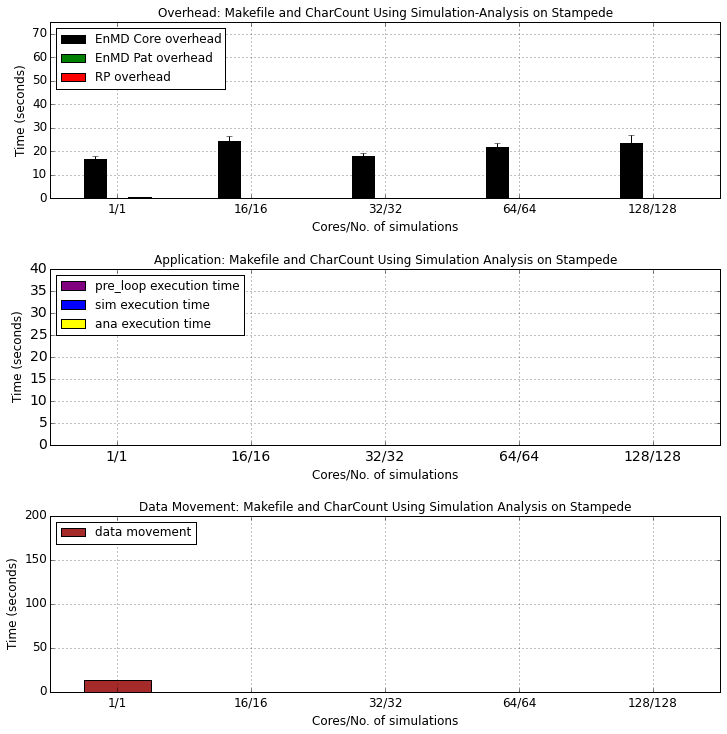

In [100]:
comp_df['RP overhead'][0] = .5
for i in range(0,len(comp_df['RP overhead'])):
    comp_df['RP overhead'][i] = abs(comp_df['RP overhead'][i])
    
comp_df['data movement'][0] = 13.592614
comp_df

separate(comp_df,err_df)
